In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

#  == impoprt qiskit ==

from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city


np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

# == Hamiltonian setup ==
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Pre_defined state ==
pauli_x = np.array([ [0, 1], [1, 0]])
pauli_y = np.array([ [0, -1.j], [1.j, 0]])
pauli_z = np.array([ [1, 0], [0, -1]])

# State = (00 + 01 + 10 + 11)/2 = kron(|0> + |1>)/sqrt(2) , (|0> + |1>)/sqrt(2) )
state_super_pos = np.kron( (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) , (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) )
rho_super_pos = np.kron(state_super_pos, state_super_pos.conj().T) 
# state_super_pos, state_super_pos.con().T has different dimension 

# Bell state = (|00> + |11>) / 2
state_bell = ( np.kron( np.array([ [1], [0] ]) , np.array([ [1], [0] ]) ) +  np.kron( np.array([ [0], [1] ]) , np.array([ [0], [1] ]) ) )/np.sqrt(2) 
# rho_bell = state_bell @ state_bell.conj().T
rho_bell = np.kron(state_bell , state_bell.conj().T)

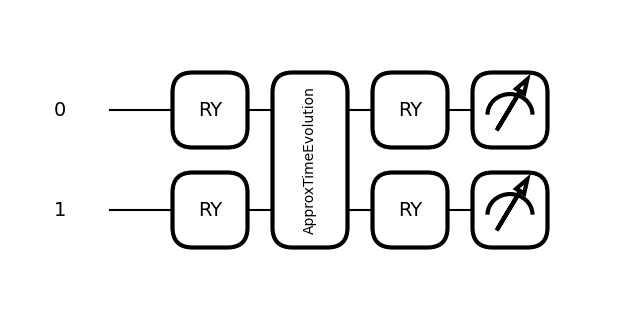

In [3]:
# == Quantum circuit ==
@qml.qnode(dev)
def circuit(theta_init, tau_1, tau_2):

    # 1st try = use only tau_1
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    
    return qml.density_matrix(wires=[0, 1]) 

fig, ax = qml.draw_mpl(circuit)(0, 1, 1)

In [4]:
# == Calculate concurrence ==
def concurrence_calculation(paras):
    
	theta_init, tau_1, tau_2 = paras
 
	rho = circuit(theta_init, tau_1, tau_2).numpy()
	# density matrix casting to numpy
	
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
	
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )
	# print('Concurrence matrix(R): \n', R)

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]
	# print('Eig_val descending order:', eig_vals)

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?
	# print('np.amax:', -concurrence)
 
	# 1-concurrence = minimum => concurrence = max!!
	return 1 - concurrence


# == Bell state concurrence ==
def concurrence_bell():
	rho = rho_bell
	rho_uni = np.kron(pauli_y, pauli_y) @ rho.conj() @ np.kron(pauli_y, pauli_y)
 
	R = sp.linalg.sqrtm( sp.linalg.sqrtm(rho) @ rho_uni @ sp.linalg.sqrtm(rho) )

	# sort array in descending order
	eig_vals = np.sort(sp.linalg.eigvals(R).real)[::-1]

	concurrence = np.amax([ 0, (2*eig_vals[0] - np.sum(eig_vals)) ])	
	# concurrence = 0 vs (2*eig_vals[0] - np.sum(eig_vals)) which is bigger?

	# 1-concurrence = minimum => concurrence = max!!
	print('Bell-state concurrence:\n', concurrence, '\n')
	
	return 1-concurrence


para = 1,1,1
print('Concurrnece before optimize:\n', -1*(concurrence_calculation(para)-1),'\n')

concurrence_bell()

Concurrnece before optimize:
 0.9092974268256816 

Bell-state concurrence:
 0.9999999999999998 



2.220446049250313e-16

Density matrix before optimization:
 [[ 7.08073418e-01+0.00000000e+00j -1.92592994e-33-8.25742030e-17j  3.30296812e-17-9.34220462e-17j -4.36337384e-17-4.54648713e-01j]
 [-1.92592994e-33+8.25742030e-17j  9.62964972e-33+0.00000000e+00j  1.08947050e-32+3.85185989e-33j  5.30202860e-17-3.85185989e-33j]
 [ 3.30296812e-17+9.34220462e-17j  1.08947050e-32-3.85185989e-33j  1.38666956e-32+0.00000000e+00j  5.99856060e-17-2.12081144e-17j]
 [-4.36337384e-17+4.54648713e-01j  5.30202860e-17+3.85185989e-33j  5.99856060e-17+2.12081144e-17j  2.91926582e-01+0.00000000e+00j]] 



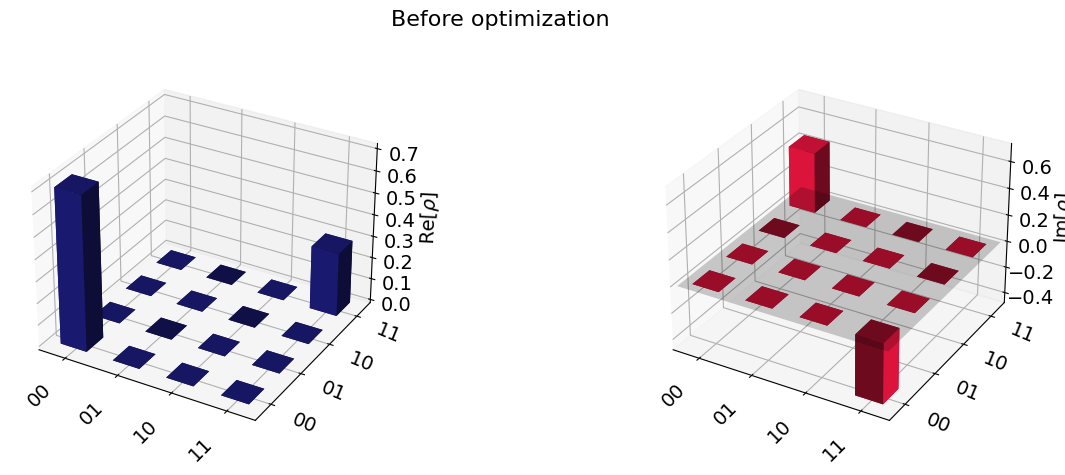

In [5]:
# == before optimize == 
density_matrix_in = circuit(1,1,1)

print('Density matrix before optimization:\n',density_matrix_in,'\n')
plot_state_city(density_matrix_in, color=['midnightblue', 'crimson'], title="Before optimization")

In [6]:
# == Optimize begin SLSQP ==

# theta / tau_1 / tau_2
Init_parameters = np.pi/4, np.pi/2, np.pi/4

result_SLSQP = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='SLSQP' )

print('\n\nconcurrence_after_optimize(max): ', -1 * (concurrence_calculation(result_SLSQP.x)-1) )

result_SLSQP



concurrence_after_optimize(max):  0.9999963295887755


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.6704112245100617e-06
       x: [ 7.854e-01  3.928e+00  7.854e-01]
     nit: 3
     jac: [ 0.000e+00  5.407e-01  0.000e+00]
    nfev: 26
    njev: 3

In [7]:
# == Optimize begin BFGS ==

# theta / tau_1 / tau_2
Init_parameters = np.pi/4, np.pi/4, np.pi/4

result_BFGS = sp.optimize.minimize(concurrence_calculation, Init_parameters, method='BFGS' )

print('\n\nconcurrence_after_optimize(max): ', -1 * (concurrence_calculation(result_BFGS.x)-1) )

print(result_BFGS)



concurrence_after_optimize(max):  0.9999999999999997
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.3306690738754696e-16
        x: [ 7.854e-01  7.854e-01  7.854e-01]
      nit: 0
      jac: [ 0.000e+00  3.725e-08  0.000e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 4
     njev: 1


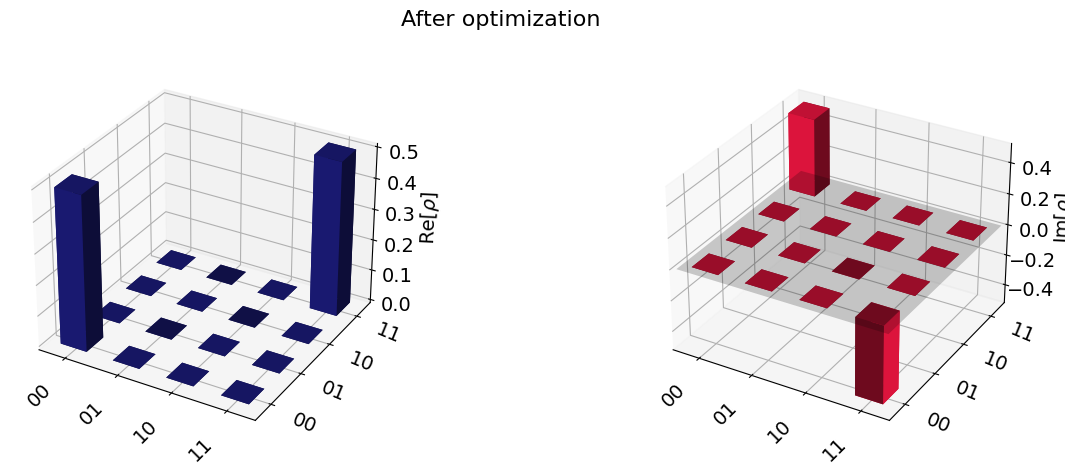

In [8]:
# == After optimize == 
density_BFGS = circuit(result_BFGS.x[0],result_BFGS.x[1],result_BFGS.x[2])

# print('density matrix after optimization:\n',density_BFGS,'\n')
plot_state_city(density_BFGS, color=['midnightblue', 'crimson'], title="After optimization")